In [39]:
import pandas as pd
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = """
SELECT
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.items,
  rx.quantity,
  rx.nic,
  dt.concession,
  dt.quantity AS dt_quantity,
  dt.price_pence,
  SUM(rx.items*rx.quantity) AS QI,
  ROUND(IEEE_DIVIDE(rx.NIC, (rx.items*rx.quantity)),4) AS rx_ppu,
  ROUND(IEEE_DIVIDE((dt.price_pence/100), dt.quantity),4) AS dt_ppu,
  CASE
    WHEN dt.concession IS NOT NULL THEN ROUND(IEEE_DIVIDE((dt.concession/100), dt.quantity), 4)
    ELSE NULL
  END AS concession_ppu
FROM
  richard.prescribing_2018_09_full AS rx
JOIN
  dmd.dt_viewer AS dt
ON
  rx.bnf_code=dt.bnf_code
JOIN
  hscic.practices AS prac
ON
  rx.practice_code=prac.code
WHERE
  (rx.bnf_description LIKE '%_Tab%'
    OR rx.bnf_description LIKE '%_Cap%')
  AND dt.date='2018-09-01'
  AND rx.bnf_code NOT LIKE '0410020C0%AC'
GROUP BY
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.quantity,
  rx.items,
  rx_ppu,
  dt_ppu,
  dt.concession,
  dt.quantity,
  dt.price_pence,
  rx.NIC
HAVING
  rx_ppu <> dt_ppu
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=cIFZfGzZI9muYwHEad2h2DKaRhT9W5&prompt=consent&access_type=offline
Enter the authorization code: 4/RAGijSXjHkwQgCjlBE7cDSX0bCWENnSCd4CqRLMjQJeOoLtIB8XHllU


In [72]:
sql = """
SELECT
  month,
  pct,
  practice,
  SUM(items) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

In [73]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2015-08-01 00:00:00+00:00,11N,L82006,17870,10.3196,81096.11
1,2015-08-01 00:00:00+00:00,11J,J81030,10038,3.6498,54565.09
2,2015-08-01 00:00:00+00:00,08A,G83067,23007,-17.5852,119785.84
3,2015-08-01 00:00:00+00:00,15C,L81663,107,0.0000,338.83
4,2015-08-01 00:00:00+00:00,15E,M85786,1883,-2.4335,9879.14


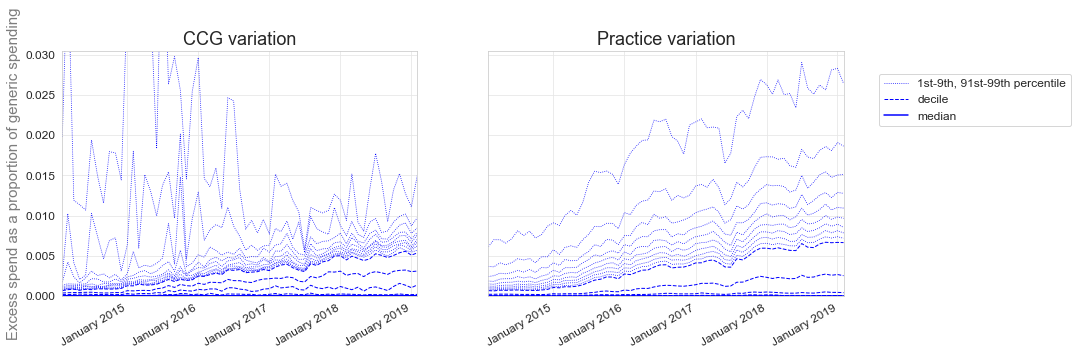

In [86]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
#f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg2,
    period_column='month',
    column='calc_val',
    title="CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice2,
    period_column='month',
    column='calc_val',
    title="Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.show()

In [85]:
practice2 = ghost_df.copy()
practice2['calc_val'] = practice2['possible_savings']/practice2['net_cost']
practice2['month'] = pd.to_datetime(practice2['month'])
practice2 = practice2.sort_values(['practice','month'])
practice2 = practice2.loc[practice2['month']>='2014-02-01']
practice2.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
5005,2014-02-01 00:00:00+00:00,00K,A81001,4218,2.4332,27133.02,0.000090
77815,2014-03-01 00:00:00+00:00,00K,A81001,4285,22.3784,29706.77,0.000753
80904,2014-04-01 00:00:00+00:00,00K,A81001,4792,2.4329,29436.55,0.000083
73749,2014-05-01 00:00:00+00:00,00K,A81001,4648,5.2480,31341.95,0.000167
95621,2014-06-01 00:00:00+00:00,00K,A81001,4995,25.5021,29629.27,0.000861


In [84]:
ccg2 = ghost_df.copy()
ccg2['month'] = pd.to_datetime(ccg2['month'])
ccg2 = ccg2.groupby(['pct','month'],as_index=False).sum()
ccg2['calc_val'] = ccg2['possible_savings']/ccg2['net_cost']
ccg2 = ccg2.sort_values(['pct','month'])
ccg2 = ccg2.loc[ccg2['month']>='2014-02-01']
ccg2.head()

,pct,month,items,possible_savings,net_cost,calc_val
42,00C,2014-02-01 00:00:00+00:00,127772,384.1036,728497.62,0.000527
43,00C,2014-03-01 00:00:00+00:00,140626,708.5111,785968.79,0.000901
44,00C,2014-04-01 00:00:00+00:00,140898,1013.7438,775619.83,0.001307
45,00C,2014-05-01 00:00:00+00:00,144857,1347.5524,794930.90,0.001695
46,00C,2014-06-01 00:00:00+00:00,146179,1506.8852,796327.49,0.001892


In [89]:
sql = '''SELECT pct_id, month, numerator, denominator FROM ebmdatalab.measures.ccg_data_ghost_generic_measure'''
ccg = bq.cached_read(sql, csv_path='ccg.zip')
ccg['calc_val'] = ccg['numerator']/ccg['denominator']
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.sort_values(['pct_id','month'])
ccg.head()

,pct_id,month,numerator,denominator,calc_val
11176,00C,2014-02-01,370.4588,718768.26,0.000515
11177,00C,2014-03-01,714.6957,774311.02,0.000923
11170,00C,2014-04-01,1013.7438,763917.36,0.001327
11195,00C,2014-05-01,1325.0524,781858.17,0.001695
11163,00C,2014-06-01,1506.8852,784131.80,0.001922


In [65]:
sql = '''SELECT practice_id, month, numerator, denominator FROM ebmdatalab.measures.practice_data_ghost_generic_measure'''
practice = bq.cached_read(sql, csv_path='practice.zip')
practice['calc_val'] = practice['numerator']/practice['denominator']
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice_id','month'])
practice.head()

,practice_id,month,numerator,denominator,calc_val
25,A81001,2014-02-01,2.4332,27133.02,0.000090
40,A81001,2014-03-01,22.3784,29706.77,0.000753
14,A81001,2014-04-01,2.4329,29436.55,0.000083
26,A81001,2014-05-01,5.2480,31341.95,0.000167
48,A81001,2014-06-01,25.5021,29629.27,0.000861


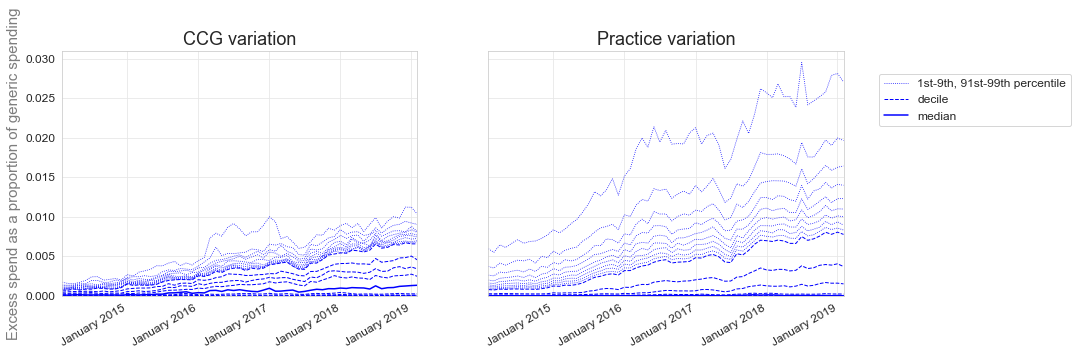

In [57]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
#f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.show()

# Most recent month map

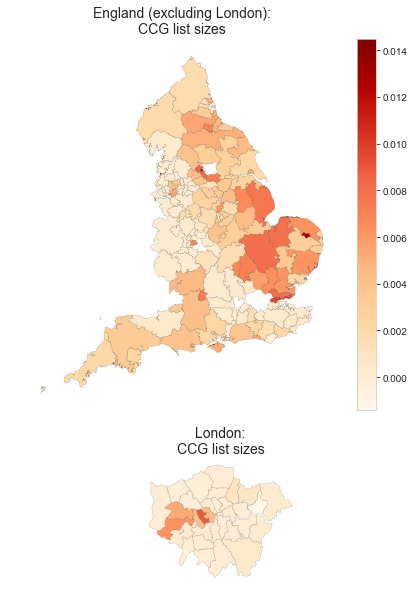

In [55]:
plt.figure(figsize=(7, 10))
ccg['pct'] = ccg['pct_id']
last_month = ccg.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title="CCG list sizes", column='calc_val', 
             separate_london=True)
plt.show()

In [7]:
ghost_df['dt_or_concession_ppu'] = ghost_df['concession_ppu'].combine_first(ghost_df['dt_ppu'])

In [8]:
total_items = ghost_df['items'].sum()
total_presentations = len(ghost_df['bnf_code'].unique())
cheaper = ghost_df[ghost_df['rx_ppu'].round(3) < ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
costlier = ghost_df[ghost_df['rx_ppu'].round(3) > ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
same = total_items - (cheaper + costlier)
print("There are {} items prescribed for {} presentations. "
      "{}% are cheaper than DT, {}% more expensive, the rest the same".format(
          total_items,
          total_presentations,
          round(cheaper/total_items * 100),
          round(costlier/total_items * 100)
      ))

There are 16781297 items prescribed for 1470 presentations. 9.0% are cheaper than DT, 29.0% more expensive, the rest the same


In [9]:
ghost_df['excess_ppu'] = ghost_df['rx_ppu'] - ghost_df['dt_or_concession_ppu']
ghost_df['excess_ppu_no_concession'] = ghost_df['rx_ppu'] - ghost_df['dt_ppu']
ghost_df['excess_cost_dt_no_concession'] = (ghost_df['excess_ppu_no_concession']) * ghost_df['QI']
ghost_df['excess_cost_dt'] = (ghost_df['excess_ppu']) * ghost_df['QI']
ghost_df = ghost_df.sort_values('excess_cost_dt', ascending=False)

# Summary numbers

In [31]:
total_savings = round(ghost_df['excess_cost_dt'].sum())
total_savings_no_concession = round(ghost_df['excess_cost_dt_no_concession'].sum())
print("Total possible savings in Sept 2018: £{}".format(total_savings))


Total possible savings in Sept 2018: £966855.0


# Top savings

In [12]:
by_presentation = ghost_df.groupby('bnf_description')[['excess_cost_dt', 'excess_ppu']].sum().reset_index()

## 1. By total cost

In [13]:
by_presentation.sort_values('excess_cost_dt',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1018,Paracet_Tab 500mg,86409.9460,45.6534
96,Atorvastatin_Tab 20mg,77029.7397,49.5081
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
98,Atorvastatin_Tab 40mg,24258.7795,22.7058


## 2. By per-unit price

In [14]:
by_presentation.sort_values('excess_ppu',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1200,Risperidone_Tab 6mg,20746.9142,566.3781
621,Ibandronic Acid_Tab 150mg,830.9200,315.5332
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
1188,Risedronate Sod_Tab 35mg,2328.0476,227.0769


# Top costs per CCG

In [15]:
gpd_ghost_df = ghost_df.groupby('ccg_id')['excess_cost_dt'].sum().reset_index().sort_values('excess_cost_dt',ascending=False)

In [16]:
gpd_ghost_df.head(10)

,ccg_id,excess_cost_dt
95,06H,36167.2935
198,15F,26294.4252
197,15E,25910.4207
177,11J,24356.5480
83,05L,22655.0496
225,99P,22106.7665
178,11M,21685.3784
94,06F,20982.5777
96,06K,19156.1250
56,03T,18192.9049


# Top costs per EPR

In [17]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,TPP,SystmOne
1,A81048,TPP,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,TPP,SystmOne
4,A86026,TPP,SystmOne


In [18]:
numbers = ghost_df[['practice_code', 'excess_cost_dt']]
by_epr = numbers.merge(epr, how='inner', left_on='practice_code', right_on='ODS')

In [53]:
by_epr.head()

,practice_code,excess_cost_dt,ODS,Principal Supplier,Principal System
0,D83008,1712.3008,D83008,TPP,SystmOne
1,D83008,90.1208,D83008,TPP,SystmOne
2,D83008,60.8076,D83008,TPP,SystmOne
3,D83008,54.9696,D83008,TPP,SystmOne
4,D83008,44.6600,D83008,TPP,SystmOne


In [66]:
summary = by_epr.groupby('Principal System')['excess_cost_dt', 'practice_code'].agg({'cost': 'sum', 'count': pd.Series.nunique})

summary.columns = ["excess_cost", "rows_count", "practice_count"]
summary['cost_per_install'] = summary['excess_cost'] / summary['practice_count']
#summary = summary.sort_values('cost_per_install', ascending=False)
summary = summary.sort_values('cost_per_install', ascending=False)

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [68]:
summary

,excess_cost,rows_count,practice_count,cost_per_install
Principal System,,,,
SystmOne,863367.109201,40982.0,2561,337.121089
Evolution,3090.119300,2884.0,57,54.212619
Vision 3 LAN,2183.878600,3177.0,56,38.997832
Vision 3 Hosted,7457.238000,6032.0,324,23.016167
EMIS Web,84118.076500,17007.0,4110,20.466685


Text(0, 0.5, 'cost per install (£)')

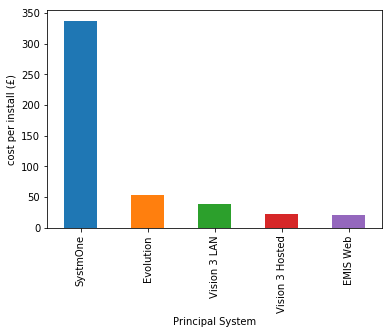

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt 
summary['cost_per_install'].plot.bar()
plt.ylabel("cost per install (£)")

# Create useful files for CCGs

In [51]:
summary = gpd_ghost_df.assign(saving_from_top_10 = None).set_index('ccg_id')
import re
import os
from zipfile import ZipFile
for ccg_id in summary.index:
    if re.match(r"^[0-9]{2}[A-Z]", ccg_id):
        ccg = ghost_df[ghost_df.ccg_id == ccg_id]
        top_presentations = ccg.groupby('bnf_description').sum().sort_values('excess_cost_dt', ascending=False).head(10).reset_index()[['bnf_description', 'excess_cost_dt']]
        target_prescriptions = top_presentations.merge(ccg, how='left', left_on='bnf_description', right_on='bnf_description').sort_values('excess_cost_dt_y', ascending=False)
        useful_cols = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost_dt_y']
        target_prescriptions = target_prescriptions[useful_cols]
        target_prescriptions = target_prescriptions.groupby(['practice_code', 'bnf_description', 'bnf_code']).sum().reset_index()
        target_prescriptions.columns = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost']
        summary.loc[ccg_id, 'saving_from_top_10'] = target_prescriptions['excess_cost'].sum()
        f = "{}.csv".format(ccg_id)
        target_prescriptions.to_csv(f)
        with ZipFile("csv_data/{}.zip".format(ccg_id), 'w') as myzip:
            myzip.write(f)
        os.remove(f)
summary = summary.reset_index()

In [33]:
summary.head()

,ccg_id,excess_cost_dt,saving_from_top_10
0,06H,36167.2935,12914.2
1,15F,26294.4252,11122.2
2,15E,25910.4207,12003.7
3,11J,24356.5480,10649
4,05L,22655.0496,9381.82
